In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import math
import random
from sklearn import preprocessing

In [2]:
#input data:processed data
data = pd.read_excel('zone_merged_reordered_136(no bot).xlsx').astype('float64')

In [4]:
features=data.columns

In [5]:
# 使用每列的众数填充该列的缺失值
for column in data.columns:
    data[column].fillna(data[column].mode()[0],inplace=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
global data_np
data_np = data.to_numpy()[:,:]

In [8]:
#归一化
min_max_scaler = preprocessing.MinMaxScaler()
data_np_scale = min_max_scaler.fit_transform(data_np)
#取最后一列
original_chlo_data = data_np[:,-1]
global max_chlo
max_chlo = np.max(original_chlo_data)
chlo_data = data_np_scale[:,-1]

In [9]:
"Optimal parameters"
global feat_num,use_len
feat_num = data_np.shape[1]
use_len = 15
pred_len = 8
hidden_dim = 128
batch_size = 64

In [10]:
#生成用于训练或测试时间序列预测模型的样本集
def create_index_set(rain_data,data_np,use_len,pred_len): 
    
    sample_size = len(rain_data)-(use_len + pred_len - 1)
    
    X_sample = np.zeros((sample_size,use_len,data_np.shape[1]))
    Y_sample = np.zeros((sample_size,pred_len))
    
    for i in range(use_len,len(rain_data)-pred_len+1):  
        Y_sample[i-use_len]= rain_data[i:i+pred_len]
        X_sample[i-use_len]= data_np[i-use_len:i,:]
            
    X_sample = X_sample.reshape(len(X_sample),use_len,data_np.shape[1])
    Y_sample = Y_sample.reshape(len(Y_sample),pred_len,1)

    return X_sample,Y_sample

In [1]:
#提取8次预测结果，滑动窗口每条记录预测8次。
def extra_result(result_data,pre_len):
    if torch.is_tensor(result_data):
        result_numpy=np.squeeze(result_data.detach().numpy().reshape(-1,1))
    else:
        result_numpy=np.squeeze(result_data.reshape(-1,1))
    indices = []
    start_index = pre_len-1  # 初始索引位置
    increment = pre_len  # 每行的增量
    
    for _ in range(int((len(result_numpy)-pred_len*(pre_len-1))/8)):  # 总共3行
        row_indices = [start_index + (pre_len-1)*i for i in range(increment)]
        indices.append(row_indices)
        start_index = row_indices[0] + pre_len
    dat = []
    # 循环遍历索引位置并提取值
    for idx_list in indices:
        row_data = []
        for idx in idx_list:
            row_data.append(result_numpy[idx])  # 索引从1开始，数组从0开始，所以需要减1
        dat.append(row_data)
    
    # 创建DataFrame
    res_df = pd.DataFrame(dat)
    res_df['mean'] = res_df.mean(axis=1)
    #Sur_Chlo_a预警阈值
    count_above = (res_df > 5).sum(axis=1)

    # 计算每行至少有一列值大于10的概率
    probability_above = count_above / res_df.shape[1]
    
    # 添加概率列到DataFrame
    res_df['Probability_above_10'] = probability_above
    return res_df

In [2]:
def single_predict(data_numpy,model):#shape of data_numpy(use_len,feature_num)
    data_numpy_tensor=torch.from_numpy(data_numpy).to(device)
    model.eval()
    output = Seq2Seq_model_1(data_numpy_tensor.float())
    return output

In [21]:
X_sample,Y_sample = create_index_set(original_chlo_data,data_np_scale,use_len,pred_len)

In [31]:
#分割训练集和测试集，分成3份，用于三次训练
X_tr_sample,X_val,Y_tr_sample,Y_val = train_test_split(X_sample,Y_sample,test_size=0.1,random_state=42,shuffle=False)
X_tr,X_1fold,Y_tr,Y_1fold = train_test_split(X_tr_sample,Y_tr_sample,test_size=0.33,random_state=42,shuffle=False)
X_2fold,X_3fold,Y_2fold,Y_3fold = train_test_split(X_tr,Y_tr,test_size=0.5,random_state=42,shuffle=False)

X1fold_tensor=torch.from_numpy(X_1fold).to(device)
Y1fold_tensor=torch.from_numpy(Y_1fold).to(device)

X2fold_tensor=torch.from_numpy(X_2fold).to(device)
Y2fold_tensor=torch.from_numpy(Y_2fold).to(device)

X3fold_tensor=torch.from_numpy(X_3fold).to(device)
Y3fold_tensor=torch.from_numpy(Y_3fold).to(device)

In [23]:
#dataset类
class TrainDataset(Dataset):
    
    def __init__(self,X_train,Y_train):

        self.input = torch.from_numpy(X_train).to(device) 
        self.output = torch.from_numpy(Y_train).to(device)  
    
    def __getitem__(self, index):
        return self.input[index], self.output[index]

    def __len__(self):
        return len(self.input)
    
#encoder
class encoder_gru(nn.Module):

    def __init__(self, input_size, hidden_size,num_layers):

        super(encoder_gru, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = torch.nn.GRU(input_size = self.input_size,hidden_size = self.hidden_size,\
                                num_layers=self.num_layers,batch_first=True).to(device)

    def forward(self, input):

        self.batch_size = input.shape[0]
        hidden_0 = torch.zeros(self.num_layers,self.batch_size,self.hidden_size).to(device)
        output1, hidden1 = self.gru(input, hidden_0)

        return output1 

class Attention(nn.Module):

    def __init__(self, hidden_size):

        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        #将输入的隐藏状态和编码器输出映射为注意力分数
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size).to(device)
        #用于计算加权和时的权重
        self.v = nn.Parameter(torch.rand(hidden_size)).to(device)

        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv).to(device)

    def forward(self, hidden, encoder_outputs):

        this_batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1).transpose(0,1) .to(device)   
        attn_energies = self.score(H,encoder_outputs).to(device) # 计算注意力分数
        return F.softmax(attn_energies,dim = 1).unsqueeze(1)  # 返回归一化后的注意力权重

    def score(self, hidden, encoder_outputs):
        #将隐藏状态和编码器输出连接起来，并经过线性层 self.attn 和 tanh 激活函数，得到注意力分数的原始形式。
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2))).to(device)
        energy = energy.transpose(2,1) 
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) 
        energy = torch.bmm(v,energy) 

        return energy.squeeze(1)

class decoder_gru_cell(nn.Module):

    def __init__(self, hidden_size, output_size, n_layers):

        super(decoder_gru_cell, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        # Define layers

        self.attn = Attention(hidden_size = self.hidden_size).to(device)
        #当前输入的大小和上下文向量的大小
        self.gru = nn.GRU(hidden_size+1, hidden_size, n_layers, batch_first= True).to(device)
        #GRU 输出映射到输出大小
        self.out = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, current_input, last_hidden, encoder_outputs):

        # 计算注意力权重并映射到输出

        current_input = current_input.unsqueeze(0).to(device)   
        attn_weights = self.attn(last_hidden, encoder_outputs).to(device)
        #上下文向量，结果为输入向量的加权平均值。
        context = attn_weights.bmm(encoder_outputs.to(device))
        #交换第0维和第1维的数据
        context = context.transpose(0, 1)  
        rnn_input = torch.cat((current_input, context), 2)   
        rnn_input = rnn_input.transpose(0,1)        
        output, hidden = self.gru(rnn_input, last_hidden.to(device))    
        output = output.squeeze(1) 
        output = torch.relu(self.out(output)) 

        return output,hidden

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder_cell,pre_len,hidden_size, decoder_layers):

        super(Seq2Seq, self).__init__()

        self.encoder = encoder.to(device)
        self.decoder_cell = decoder_cell.to(device)
        self.pre_len = pre_len
        self.hidden_size = hidden_size   
        self.decoder_layers = decoder_layers 

    def forward(self,input):
        batch_size = input.size(0)
        use_len = input.size(1)
        feat_num = input.size(2)
        encoder_outputs = self.encoder(input)

        outputs = torch.zeros(self.pre_len,batch_size,1)
        current_input = input[:,-1,-1].reshape(batch_size,1)  # current_input: [B,1]
        last_hidden = torch.zeros(self.decoder_layers,batch_size,self.hidden_size).to(device)
        #核心，通过循环进行解码，每次调用解码器单元得到当前时刻的输出和更新后的隐藏状态。将当前输出添加到 outputs 中，并将其作为下一时刻的输入
        for i in range(self.pre_len):

            output,hidden = self.decoder_cell(current_input, last_hidden, encoder_outputs)
            current_input = output
            last_hidden = hidden
            #(batch_size, output_size)
            outputs[i] = output

        outputs = outputs.transpose(0,1) #outputs:(B,pre_len,1)
        outputs = outputs*max_chlo

        return outputs



In [24]:
def evaluate_model(set_tensor,tar_tensor,model,criterion):
    model.eval()
    output = model(set_tensor.float())
    #reshape,自动计算维度，转化为（m*n，1）
    res_output = output.reshape(-1,1).to(device)
    target=tar_tensor.reshape(-1,1).to(device)
    #此处可添加评价指标代码
    MSE = criterion(res_output, target)
    R2= r2_score(target.cpu().numpy(),res_output.cpu().numpy())
    return tar_tensor.cpu().numpy(),output.cpu().numpy(),MSE.item(),R2


Train the 1st fold,X_1fold serves as the test set

In [29]:
encoder_1 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1).to(device)
decoder_cell_1 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1).to(device)
Seq2Seq_model_1 = Seq2Seq(encoder_1, decoder_cell_1,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1).to(device)

X_train_1  = np.concatenate((X_2fold,X_3fold),axis = 0)
Y_train_1 = np.concatenate((Y_2fold,Y_3fold),axis = 0)
X_train_1_tensor = torch.from_numpy(X_train_1).to(device)
Y_train_1_tensor = torch.from_numpy(Y_train_1).to(device)

trainset_1 = TrainDataset(X_train_1, Y_train_1)
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size)
criterion_1 = torch.nn.MSELoss()  
optimizer_1 = torch.optim.Adam(Seq2Seq_model_1.parameters(),lr=0.001,weight_decay=0.01)
scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_1,T_max =32,eta_min = 0, last_epoch=-1)

In [30]:
N_EPOCHS_1 = 300
train_MSEloss_1=[]
test_MSEloss_1=[]
#推理与训练
best_test_loss_1 = 1000000
model_path='Prediction\\0510S2S15to8.pth'
for epoch in range(1, N_EPOCHS_1+1):

    print(" %d epoch ... " % epoch)
    Seq2Seq_model_1.train()
    for i, (hist, target) in enumerate(trainloader_1, 1):   
        hist = hist.float()
        output = Seq2Seq_model_1(hist).to(device)
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1).to(device)
        loss = criterion_1(output, target)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
        scheduler_1.step()

    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_1_tensor,Y_train_1_tensor,Seq2Seq_model_1,criterion_1)
        train_MSEloss_1.append(train_MSE)

        _,_,test_MSE,test_R2 = evaluate_model(X1fold_tensor,Y1fold_tensor,Seq2Seq_model_1,criterion_1)
        test_MSEloss_1.append(test_MSE)

        if test_MSE < best_test_loss_1:
            best_test_loss_1 = test_MSE
            torch.save(Seq2Seq_model_1.state_dict(),model_path) 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_1fold = Seq2Seq(encoder_1, decoder_cell_1,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)
best_Seq2Seq_model_1fold.load_state_dict(torch.load(model_path))

with torch.no_grad():  

    print("testing best model……")

    test_true_1fold,test_pred_1fold,test_MSE_1fold,test_R2_1fold = evaluate_model(X1fold_tensor,Y1fold_tensor,\
                                                                                  best_Seq2Seq_model_1fold,criterion_1)

    print(f'test 1 fold MSE: {test_MSE_1fold}')
    print(f'test 1 fold R2: {test_R2_1fold}')
    plt.figure(3)
    plt.scatter(test_pred_1fold,test_true_1fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,40]),np.array([0,40]))
    plt.xlabel('pred')
    plt.ylabel('true')
    plt.savefig('0510S2S15to8test.jpg')


    train_true_1fold, train_pred_1fold, train_MSE_1fold, train_R2_1fold = evaluate_model(
    X_train_1_tensor, Y_train_1_tensor, best_Seq2Seq_model_1fold, criterion_1
)

    print(f'train 1 fold MSE: {train_MSE_1fold}')
    print(f'train 1 fold R2: {train_R2_1fold}')
    plt.figure(5)
    plt.scatter(train_pred_1fold,train_true_1fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,45]),np.array([0,45]))
    plt.xlabel('pred')
    plt.ylabel('true')
    plt.savefig('0510S2S15to8train.jpg')

 1 epoch ... 
best test R2 at this time -0.7631057448921077
 2 epoch ... 
 3 epoch ... 
 4 epoch ... 
 5 epoch ... 
 6 epoch ... 


KeyboardInterrupt: 

In [52]:
#validate
X_val_tensor=torch.from_numpy(X_val).to(device)
Y_val_tensor=torch.from_numpy(Y_val).to(device)

In [54]:
with torch.no_grad():  
    test_true_1fold,test_pred_1fold,test_MSE_1fold,test_R2_1fold = evaluate_model(X_val_tensor,Y_val_tensor,\
                                                                                  Seq2Seq_model_1,criterion_1)
    print(f'test 1 fold MSE: {test_MSE_1fold}')
    print(f'test 1 fold R2: {test_R2_1fold}')

test 1 fold MSE: 14.609736515600884
test 1 fold R2: 0.5758841317361915


Part2：绘制预测趋势图

In [33]:
#result list prediction
encoder_1 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1).to(device)
decoder_cell_1 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1).to(device)
Seq2Seq_model_1 = Seq2Seq(encoder_1, decoder_cell_1,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1).to(device)

state_dict = torch.load('Prediction\\0428S2S15to8.pth')  # Load the state_dict
Seq2Seq_model_1.load_state_dict(state_dict)  # Load the parameters into your model


<All keys matched successfully>

In [34]:
X_train_1  = np.concatenate((X_2fold,X_3fold),axis = 0)
Y_train_1 = np.concatenate((Y_2fold,Y_3fold),axis = 0)
X_train_1_tensor = torch.from_numpy(X_train_1).to(device)
Y_train_1_tensor = torch.from_numpy(Y_train_1).to(device)

trainset_1 = TrainDataset(X_train_1, Y_train_1)
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size)
criterion_1 = torch.nn.MSELoss()  
optimizer_1 = torch.optim.Adam(Seq2Seq_model_1.parameters(),lr=0.005,weight_decay=0.01)
scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_1,T_max =32,eta_min = 0, last_epoch=-1)

In [43]:
#分割训练集和测试集，分成3份，用于三次训练
X_tr_sample,X_val,Y_tr_sample,Y_val = train_test_split(X_sample,Y_sample,test_size=0.1,random_state=42,shuffle=False)
X_tr,X_1fold,Y_tr,Y_1fold = train_test_split(X_tr_sample,Y_tr_sample,test_size=0.33,random_state=42,shuffle=False)
X_2fold,X_3fold,Y_2fold,Y_3fold = train_test_split(X_tr,Y_tr,test_size=0.5,random_state=42,shuffle=False)

X1fold_tensor=torch.from_numpy(X_1fold).to(device)
Y1fold_tensor=torch.from_numpy(Y_1fold).to(device)


In [44]:
result_list=[]
for time in range(1,11):
    Seq2Seq_model_1.train()
    for i, (hist, target) in enumerate(trainloader_1, 1):
        hist = hist.float()
        output = Seq2Seq_model_1(hist).to(device)
        output = output.reshape(-1, 1)
        target = target.float().reshape(-1, 1).to(device)
        loss = criterion_1(output, target)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
        scheduler_1.step()
    Seq2Seq_model_1.eval()  # 设置模型为评估模式
    # 假设您的测试数据是一个张量 input_data
    output = Seq2Seq_model_1(X1fold_tensor.float())
    result_list.append(output.detach().numpy().reshape(-1,1))
    # 创建一个空的 DataFrame


In [45]:
result_df=pd.DataFrame(np.squeeze(result_list))
result_df=result_df.T

In [63]:
#保存模型预测结果
result_df.to_csv("20240510prediction_result.csv")

In [64]:
grah_df=result_df.iloc[27:50]

In [47]:
df_y=pd.DataFrame(np.squeeze(Y1fold_tensor.cpu().numpy().reshape(-1,1)))

In [48]:
graph_df_y=df_y.iloc[27:50]

In [68]:
grah_df.iloc[0:15]=graph_df_y.iloc[0:15]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


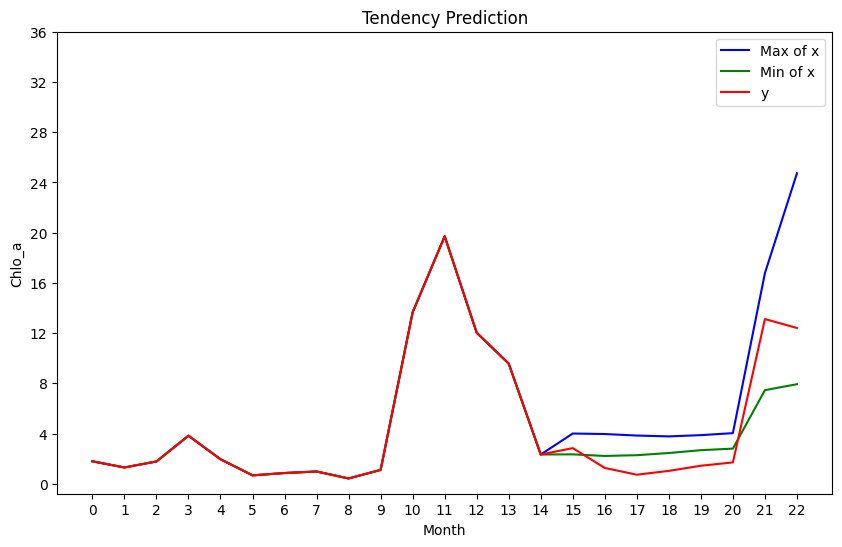

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有x和y的数据
x = grah_df.to_numpy() 
y = graph_df_y.to_numpy()    

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制x的最大值和最小值
ax.plot(np.max(x, axis=1), label='Max of x', color='blue')
ax.plot(np.min(x, axis=1), label='Min of x', color='green')

# 绘制y的数据
ax.plot(y, label='y', color='red')

# 添加标题和标签
ax.set_title('Tendency Prediction')
ax.set_xlabel('Month')
ax.set_ylabel('Chlo_a')

# 添加图例
ax.legend()
ax.set_xticks(range(0, 23))
ax.set_yticks(range(0, 40, 4))

# 保存图形
fig.savefig('0411S2S15to8_tendency_prediction_8months.jpg')

# 显示图形
plt.show()



In [21]:
pd.DataFrame(data=test_true_1fold.reshape(-1,)).to_csv('Prediction\\test_true_1fold.csv')
pd.DataFrame(data=test_pred_1fold.reshape(-1,)).to_csv('Prediction\\test_pred_1fold.csv')

In [19]:
weight_matrix=decoder_cell_1.attn.attn.weight

In [32]:
SHAP_VALUE = np.zeros([pred_len,len(X_sample),use_len,feat_num])

In [70]:
X_sample.shape

(6938, 15, 37)

In [ ]:
import shap
torch.backends.cudnn.enabled = False
allset_tensor = torch.from_numpy(X_sample).to(device)
background = allset_tensor.float()

e_1 = shap.GradientExplainer(best_Seq2Seq_model_1fold,background)
shap_values_1fold = e_1.shap_values(X1fold_tensor.float())
shap_values_1fold = np.array(shap_values_1fold) 

np.save('Explanation\shap_values_1fold411.npy',shap_values_1fold)

# scale the shap values
for i in range(shap_values_1fold.shape[0]):   
    for j in range(shap_values_1fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_1fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_1fold[i,j]

至此为一折完整的训练

Train the 2nd fold,X_2fold serves as the test set

In [104]:
encoder_2 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1).to(device)
decoder_cell_2 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1).to(device)
Seq2Seq_model_2 = Seq2Seq(encoder_2, decoder_cell_2,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1).to(device)

X_train_2  = np.concatenate((X_1fold,X_3fold),axis = 0)
Y_train_2 = np.concatenate((Y_1fold,Y_3fold),axis = 0)
X_train_2_tensor = torch.from_numpy(X_train_2).to(device)
Y_train_2_tensor = torch.from_numpy(Y_train_2).to(device)

trainset_2 = TrainDataset(X_train_2, Y_train_2)
trainloader_2 = DataLoader(trainset_2, batch_size=batch_size, shuffle=True)
criterion_2 = torch.nn.MSELoss()  
optimizer_2 = torch.optim.Adam(Seq2Seq_model_2.parameters(), lr=0.01,weight_decay =0.01)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_2,T_max = 32,eta_min = 0, last_epoch=-1)

 1 epoch ... 
best test R2 at this time -0.10317799117087323
 2 epoch ... 
best test R2 at this time -0.002776481511050255
 3 epoch ... 
best test R2 at this time 0.019823256131696332
 4 epoch ... 
 5 epoch ... 
 6 epoch ... 
 7 epoch ... 
best test R2 at this time 0.04443190465122815
 8 epoch ... 
 9 epoch ... 
 10 epoch ... 
best test R2 at this time 0.06397512025385221
 11 epoch ... 
 12 epoch ... 
 13 epoch ... 
 14 epoch ... 
 15 epoch ... 
best test R2 at this time 0.0900645030930517
 16 epoch ... 
 17 epoch ... 
best test R2 at this time 0.093807935360948
 18 epoch ... 
 19 epoch ... 
best test R2 at this time 0.11531474765540317
 20 epoch ... 
best test R2 at this time 0.1257152351899975
 21 epoch ... 
best test R2 at this time 0.12582966845176458
 22 epoch ... 
 23 epoch ... 
 24 epoch ... 
best test R2 at this time 0.13166306908590486
 25 epoch ... 
best test R2 at this time 0.13783759166231957
 26 epoch ... 
 27 epoch ... 
 28 epoch ... 
 29 epoch ... 
best test R2 at this t

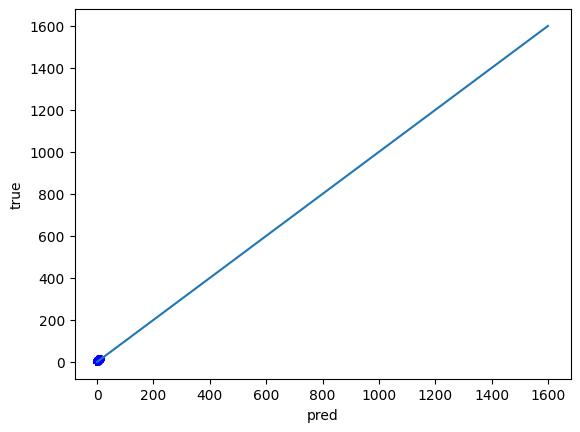

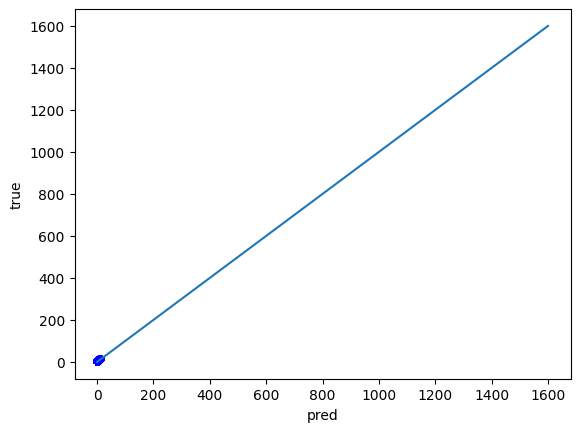

In [106]:

N_EPOCHS_2 = 300

train_MSEloss_2=[]
test_MSEloss_2=[]

best_test_loss_2 = 1000000

for epoch in range(1, N_EPOCHS_2+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_2.train()
    for i, (hist, target) in enumerate(trainloader_2, 1):   
        hist = hist.float()
        output = Seq2Seq_model_2(hist).to(device) 
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1).to(device)
        loss = criterion_2(output, target)
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()
        scheduler_2.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_2_tensor,Y_train_2_tensor,Seq2Seq_model_2,criterion_2)
        train_MSEloss_2.append(train_MSE)
        
        _,_,test_MSE,test_R2 = evaluate_model(X2fold_tensor,Y2fold_tensor,Seq2Seq_model_2,criterion_2)
        test_MSEloss_2.append(test_MSE)

        if test_MSE < best_test_loss_2:
            best_test_loss_2 = test_MSE
            torch.save(Seq2Seq_model_2.state_dict(),'Prediction\\0118S2S12to12best_model_2fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_2fold = Seq2Seq(encoder_2, decoder_cell_2,pre_len=pred_len,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_2fold.load_state_dict(torch.load('Prediction\\0118S2S12to12best_model_2fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_2fold,test_pred_2fold,test_MSE_2fold,test_R2_2fold = evaluate_model(X2fold_tensor,Y2fold_tensor,\
                                                                                  best_Seq2Seq_model_2fold,criterion_2)
    
    print(f'Test 2 fold MSE: {test_MSE_2fold}')
    print(f'Test 2 fold R2: {test_R2_2fold}')
    plt.figure(3)
    plt.scatter(test_pred_2fold,test_true_2fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_2fold,train_pred_2fold,train_MSE_2fold,train_R2_2fold = evaluate_model(X_train_2_tensor,Y_train_2_tensor,\
                                                                                      best_Seq2Seq_model_2fold,criterion_2)
    
    print(f'train 2 fold MSE: {train_MSE_2fold}')
    print(f'train 2 fold R2: {train_R2_2fold}')
    plt.figure(5)
    plt.scatter(train_pred_2fold,train_true_2fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [109]:
torch.backends.cudnn.enabled = False
e_2 = shap.GradientExplainer(best_Seq2Seq_model_2fold,background)
shap_values_2fold = e_2.shap_values(X2fold_tensor.float())
shap_values_2fold = np.array(shap_values_2fold)

np.save('Explanation\shap_values_2fold.npy',shap_values_2fold)

# scale the shap values
for i in range(shap_values_2fold.shape[0]):   
    for j in range(shap_values_2fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_2fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_2fold[i,j]

Train the 3rd fold,X_3fold serves as the test set

In [24]:
encoder_3 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1).to(device) 
decoder_cell_3 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1).to(device) 
Seq2Seq_model_3 = Seq2Seq(encoder_3, decoder_cell_3,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1).to(device) 

X_train_3  = np.concatenate((X_1fold,X_2fold),axis = 0)
Y_train_3 = np.concatenate((Y_1fold,Y_2fold),axis = 0)
X_train_3_tensor = torch.from_numpy(X_train_3).to(device) 
Y_train_3_tensor = torch.from_numpy(Y_train_3).to(device) 

trainset_3 = TrainDataset(X_train_3, Y_train_3)
trainloader_3 = DataLoader(trainset_3, batch_size=batch_size, shuffle=True)
criterion_3 = torch.nn.MSELoss() 
optimizer_3 = torch.optim.Adam(Seq2Seq_model_3.parameters(), lr=0.01,weight_decay =0.01) 
scheduler_3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_3,T_max = 32,eta_min = 0, last_epoch=-1)

 1 epoch ... 
best test R2 at this time -0.005799193229017341
 2 epoch ... 
best test R2 at this time -0.0028400233615488713
 3 epoch ... 
best test R2 at this time -0.00027079533813600953
 4 epoch ... 
 5 epoch ... 
best test R2 at this time 0.0020905918473520524
 6 epoch ... 
best test R2 at this time 0.002188720273572531
 7 epoch ... 
 8 epoch ... 
best test R2 at this time 0.0051097568304353524
 9 epoch ... 
best test R2 at this time 0.007616836233912516
 10 epoch ... 
best test R2 at this time 0.015188719600838119
 11 epoch ... 
best test R2 at this time 0.01640581375180572
 12 epoch ... 
best test R2 at this time 0.03316189292388905
 13 epoch ... 
best test R2 at this time 0.09563010896695012
 14 epoch ... 
best test R2 at this time 0.22070123513596318
 15 epoch ... 
best test R2 at this time 0.35165074592692447
 16 epoch ... 
best test R2 at this time 0.3637400834816442
 17 epoch ... 
best test R2 at this time 0.494810193341907
 18 epoch ... 
best test R2 at this time 0.60046678

 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
best test R2 at this time 0.7081436428749478
 336 epoch ... 
 337 epoch ... 
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
best test R2 at this time 0.709928727077423
 341 epoch ... 
 342 epoch ... 
 343 epoch ... 
 344 epoch ... 
 345 epoch ... 
 346 epoch ... 
best test R2 at this time 0.7143932412966453
 347 epoch ... 
 348 epoch ... 
 349 epoch ... 
 350 epoch ... 
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
 355 epoch ... 
 356 epoch ... 
 357 epoch ... 
 358 epoch ... 
 359 epoch ... 
 360 epoch ... 
best test R2 at this time 0.7151904064666681
 361 epoch ... 
 362 epoch ... 
 363 epoch ... 
 364 epoch ... 
 365 epoch ... 
 366 epoch ... 
 367 epoch ... 
 368 epoch ... 
 369 epoch ... 
 370 epoch ... 
 371 epoch ... 
 372 epoch ... 
 373 epoch ... 
 374 epoch ... 
 375 epoch ... 
 376 epoch ... 
 377 epoch ... 
 378 epoch ... 
 379 epoch ... 
best test R2 at this time 0.7204918891100305
 380 epoch ... 
best tes

best test R2 at this time 0.8002552422607726
 711 epoch ... 
 712 epoch ... 
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
best test R2 at this time 0.8019360219291989
 716 epoch ... 
 717 epoch ... 
 718 epoch ... 
 719 epoch ... 
 720 epoch ... 
best test R2 at this time 0.8035779536742376
 721 epoch ... 
 722 epoch ... 
 723 epoch ... 
 724 epoch ... 
 725 epoch ... 
 726 epoch ... 
 727 epoch ... 
 728 epoch ... 
 729 epoch ... 
best test R2 at this time 0.8055130902190988
 730 epoch ... 
 731 epoch ... 
 732 epoch ... 
 733 epoch ... 
 734 epoch ... 
 735 epoch ... 
 736 epoch ... 
 737 epoch ... 
 738 epoch ... 
 739 epoch ... 
best test R2 at this time 0.8098038706685751
 740 epoch ... 
 741 epoch ... 
 742 epoch ... 
 743 epoch ... 
 744 epoch ... 
 745 epoch ... 
 746 epoch ... 
 747 epoch ... 
 748 epoch ... 
 749 epoch ... 
 750 epoch ... 
 751 epoch ... 
 752 epoch ... 
 753 epoch ... 
 754 epoch ... 
 755 epoch ... 
 756 epoch ... 
 757 epoch ... 
 758 epoch ... 
 759 ep

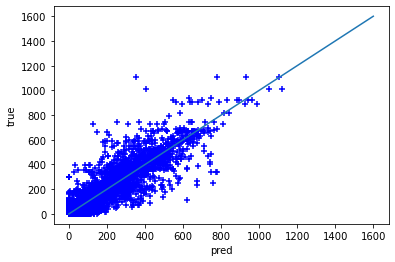

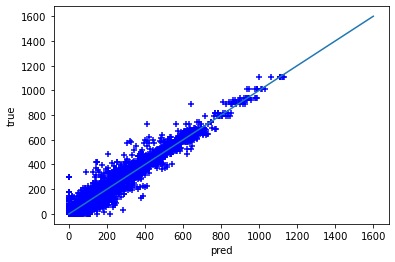

In [26]:

N_EPOCHS_3 = 3000

train_MSEloss_3=[]
test_MSEloss_3=[]

best_test_loss_3 = 1000000

for epoch in range(1, N_EPOCHS_3+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_3.train()
    for i, (hist, target) in enumerate(trainloader_3, 1):   
        hist = hist.float()
        output = Seq2Seq_model_3(hist).to(device) 
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1).to(device)
        loss = criterion_3(output, target)
        optimizer_3.zero_grad()
        loss.backward()
        optimizer_3.step()
        scheduler_3.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_3_tensor,Y_train_3_tensor,Seq2Seq_model_3,criterion_3)
        train_MSEloss_3.append(train_MSE)
        
        _,_,test_MSE,test_R2 = evaluate_model(X3fold_tensor,Y3fold_tensor,Seq2Seq_model_3,criterion_3)
        test_MSEloss_3.append(test_MSE)

        if test_MSE < best_test_loss_3:
            best_test_loss_3 = test_MSE
            torch.save(Seq2Seq_model_3.state_dict(),'Prediction\\0118S2S12to12best_model_3fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_3fold = Seq2Seq(encoder_3, decoder_cell_3,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_3fold.load_state_dict(torch.load('Prediction\\0118S2S12to12best_model_3fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_3fold,test_pred_3fold,test_MSE_3fold,test_R2_3fold = evaluate_model(X3fold_tensor,Y3fold_tensor,\
                                                                                  best_Seq2Seq_model_3fold,criterion_3)
    
    print(f'Test 3 fold MSE: {test_MSE_3fold}')
    print(f'Test 3 fold R2: {test_R2_3fold}')
    plt.figure(3)
    plt.scatter(test_pred_3fold,test_true_3fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_3fold,train_pred_3fold,train_MSE_3fold,train_R2_3fold = evaluate_model(X_train_3_tensor,Y_train_3_tensor,\
                                                                                      best_Seq2Seq_model_3fold,criterion_3)
    
    print(f'train 3 fold MSE: {train_MSE_3fold}')
    print(f'train 3 fold R2: {train_R2_3fold}')
    plt.figure(5)
    plt.scatter(train_pred_3fold,train_true_3fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [27]:
torch.backends.cudnn.enabled = False
e_3 = shap.GradientExplainer(best_Seq2Seq_model_3fold,background)
shap_values_3fold = e_3.shap_values(X3fold_tensor.float())
shap_values_3fold = np.array(shap_values_3fold)  

np.save('Explanation\shap_values_3fold.npy',shap_values_3fold)

# scale the shap values
for i in range(shap_values_3fold.shape[0]):   
    for j in range(shap_values_3fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_3fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_3fold[i,j]

Gather the test results of the three folds

In [28]:
Y_sample_new = np.zeros([len(Y_sample),pred_len*2,1])
for i in range(len(test_true_1fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_1fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_1fold[i]   
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_1fold[i] 

for i in range(len(test_true_2fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_2fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_2fold[i]   
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_2fold[i] 
    
for i in range(len(test_true_3fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_3fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_3fold[i]
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_3fold[i] 
    
Y_sample_new = Y_sample_new.squeeze(2)    

In [29]:
first_graph_data = np.zeros([len(Y_sample_new)-12,pred_len+1])
for i in range(len(Y_sample_new)-12):  
    first_graph_data[i,0] = Y_sample_new[i+1,11]
    for j in range(1,13):
        first_graph_data[i,j] = Y_sample_new[i+13-j
        ,11+j]
first_graph_data_all = first_graph_data[0:-1]

In [30]:
sec_graph_data = first_graph_data_all #shape:[1164,13]
sec_matrix = np.zeros([12,12])
for i in range(12):
    data_4_i = sec_graph_data[i::12,:]
    for j in range(12): 
        true = data_4_i[:,0]
        pred_ahead_j = data_4_i[:,j+1]
        sec_matrix[i,j] = r2_score(true,pred_ahead_j) 
#sec_matrix can be used to plot Fig.12, i.e., R2 of rainfall prediction in different calendar months with different lead months#

Output the prediction results on the test sets of the three folds

In [31]:
pd.DataFrame(data=sec_matrix).to_csv('Prediction\sec_matrix.csv')
pd.DataFrame(data=test_true_1fold.reshape(-1,)).to_csv('Prediction\test_true_1fold.csv')
pd.DataFrame(data=test_pred_1fold.reshape(-1,)).to_csv('Prediction\test_pred_1fold.csv')
pd.DataFrame(data=test_true_2fold.reshape(-1,)).to_csv('Prediction\test_true_2fold.csv')
pd.DataFrame(data=test_pred_2fold.reshape(-1,)).to_csv('Prediction\test_pred_2fold.csv')
pd.DataFrame(data=test_true_3fold.reshape(-1,)).to_csv('Prediction\test_true_3fold.csv')
pd.DataFrame(data=test_pred_3fold.reshape(-1,)).to_csv('Prediction\test_pred_3fold.csv')

Gather the explanation results on the test sets of the three folds

Part3：结果解释部分

In [32]:
shap_values = SHAP_VALUE.transpose((0,1,3,2))  
np.save('Explanation\SHAP_VALUE.npy',SHAP_VALUE)
np.save('Explanation\shap_values.npy',shap_values)

In [33]:
shap_values.shape

(12, 1177, 13, 12)

In [34]:
def shap_for_month(mon,lt): #mon: 1~12 representing Jan to Dec，lt：1~12 representing lead month
    
    lt = lt - 1 
    feat_index_tab = []
    feat_x_tab = []

    feat_name = ['mon_rain_sum','max_temp_mean','min_temp_mean','radiation_mean','rh_tmax_mean','rh_tmin_mean','SOI','NINO 12',\
                 'NINO 3','NINO 3.4','NINO 4','DMI','PDO']
    feat_x_name = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13']
    minus_time = [lt+12,lt+11,lt+10,lt+9,lt+8,lt+7,lt+6,lt+5,lt+4,lt+3,lt+2,lt+1]
    t_minus_time = ['t-'+str(k) for k in minus_time]
    
    for i in range(feat_num): 
        for j in range(use_len): 
            feat_index_tab.append(feat_name[i]+'_'+t_minus_time[j])
            feat_x_tab.append(feat_x_name[i]+'_'+t_minus_time[j])
            
    shap_lt = shap_values[lt] #shap_lt shape: 1177,13,12
    if lt <= mon-1:
        begin = mon-lt-1 
        mon_y_rain = data_np[mon+11::12,0]
    else:
        begin = mon-lt+11
        mon_y_rain = data_np[mon+23::12,0]
        
    shap_lt_mon = shap_lt[begin::12]  #shap_lt_mon: num_mon,feat_num,use_len
    
    #Calculate the attribution for each feature
    
    feat_sum = np.sum(shap_lt_mon,axis=2)  
    feat_shap_score = np.zeros((feat_num,))
    for i in range(feat_num):
        feat_shap_score[i] = np.mean((abs(feat_sum[:,i])))
    sort_feat_shap = np.sort(feat_shap_score)[::-1]    
    sort_feat_index = feat_shap_score.argsort()[-1::-1]      
    sort_feat_name = [feat_name[k] for k in sort_feat_index]  
    sort_feat_x_name = [feat_x_name[k] for k in sort_feat_index]  
    feat_importance = pd.DataFrame(data=[sort_feat_name,sort_feat_x_name,sort_feat_shap,sort_feat_index],index=\
                 ['sort_feat_name','sort_feat_x_name','sort_feat_shap','sort_feat_index']).transpose()
    
    #Calculate the attribution for each time step
    
    time_sum = np.sum(shap_lt_mon,axis=1)  
    time_shap_score = np.zeros((use_len,))
    for i in range(use_len):
        time_shap_score[i] = np.mean((abs(time_sum[:,i])))
    sort_time_shap = np.sort(time_shap_score)[::-1]    
    sort_time_index = time_shap_score.argsort()[-1::-1]      
    sort_time_name = [t_minus_time[k] for k in sort_time_index]  
    time_importance = pd.DataFrame(data=[sort_time_name,sort_time_shap,sort_time_index],index=\
                 ['sort_time_name','sort_time_shap','sort_time_index']).transpose()
    
    shap_lt_mon_resha = shap_lt_mon.reshape(-1,feat_num*use_len)

    cores_feat = np.zeros(shap_lt_mon_resha.shape)
    for i in range(cores_feat.shape[0]):   
        for j in range(feat_num):          
            cores_feat[i,j*12:(j+1)*12] = data_np[begin+12*i:begin+12+12*i,j]           
            
            
    shap_score = np.zeros((feat_num*use_len,))
    for i in range(feat_num*use_len):
        shap_score[i] = np.mean((abs(shap_lt_mon_resha[:,i])))
    sort_shap_score = np.sort(shap_score)[::-1]    
    sort_shap_index = shap_score.argsort()
    sort_shap_index = sort_shap_index[-1::-1]      
    sort_shap_feat_name = [feat_index_tab[k] for k in sort_shap_index]  
    sort_shap_x_name = [feat_x_tab[k] for k in sort_shap_index]  
    
    top = 20
    sort_shap_allpoint = np.zeros([shap_lt_mon.shape[0],top])
    sort_shap_allfeat = np.zeros([shap_lt_mon.shape[0],top])

    for i in range(top):  
        
        sort_shap_allpoint[:,i] = shap_lt_mon_resha[:,sort_shap_index[i]]      #1164,322
        sort_shap_allfeat[:,i] = cores_feat[:,sort_shap_index[i]]       #1164,322
    
    sort_shap_feat_scaler = preprocessing.MinMaxScaler()
    sort_shap_allfeat_scale = sort_shap_feat_scaler.fit_transform(sort_shap_allfeat)
    
    feat_time_importance = pd.DataFrame(data=[sort_shap_score,sort_shap_feat_name,sort_shap_x_name],index=\
                 ['sort_shap_score','sort_shap_feat_name','sort_shap_x_name']).transpose()
    
    return feat_time_importance,sort_shap_allpoint,sort_shap_allfeat_scale,sort_shap_allfeat,mon_y_rain,\
            feat_importance,time_importance 

Output the explanation results for January rainfall in Darwin (lead month = 8)

In [35]:
feat_time_importance1,sort_shap_allpoint1,sort_shap_allfeat_scale1,\
 sort_shap_allfeat1,mon_y_rain1,feat_importance1,time_importance1 = shap_for_month(1,8)

In [36]:
feat_time_importance1.to_csv(r'Explanation\feat_time_importance1.csv')
pd.DataFrame(data=sort_shap_allpoint1).to_csv(r'Explanation\sort_shap_allpoint1.csv')
pd.DataFrame(data=sort_shap_allfeat_scale1).to_csv(r'Explanation\sort_shap_allfeat_scale1.csv')
pd.DataFrame(data=sort_shap_allfeat1).to_csv(r'Explanation\sort_shap_allfeat1.csv')
pd.DataFrame(data=mon_y_rain1).to_csv(r'Explanation\mon_y_rain1.csv')
feat_importance1.to_csv(r'Explanation\feat_importance1.csv')
time_importance1.to_csv(r'Explanation\time_importance1.csv')